In [1]:
# IMPORTS
import os
from datasets import DatasetDict
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer, EarlyStoppingCallback
from transformers import set_seed as t_set_seed
import torch
import torch.nn as nn
import torchaudio 
import torchaudio.transforms as T
import numpy as np
from datasets import Dataset
import random
from PIL import Image, ImageOps
import evaluate
from transformers import EvalPrediction
from peft import LoraConfig, get_peft_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, classification_report, precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import shutil, os
import librosa
import math
import numpy as np

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed):
    #random.seed(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    t_set_seed(seed)

In [ ]:
# PARAMETERS
training_size = int(input("Enter the amount of spectrograms per class to train on (0 for all): ")) # Number of spectrograms per class to use for training (0 for all)
segments_path = "./segments"
model_output_dir = "./vit-base-manuai" # Fine-tuned model output directory
adapters_dir = "./manuai_lora_adapters" # LoRA adapters output directory
checkpoints_dir = "./manuai_checkpoints" # Checkpoints output directory

model_name = "google/vit-base-patch16-224-in21k"
# Check if checkpoints dir contains "runs" subdirectory
if os.path.exists(checkpoints_dir + "/runs"):
    model_name = checkpoints_dir
    print("Using existing fine-tuned model as base.")

processor = ViTImageProcessor.from_pretrained(model_name)  # Use the processor from the pre-trained model
sample_rate = 22050
epochs = 30
batch_size = 16
n_proc = 3 # Number of processes for parallel processing
seed = 42
segment_len = 4.0
lora_rank = 32
image_size = 224  # ViT base model image size
spectrogram_mode = "log-mel"
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

training_args = TrainingArguments(
    output_dir=checkpoints_dir, 
    learning_rate=1e-4,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    gradient_accumulation_steps=2,
    weight_decay=0.005,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    bf16=False,
    logging_steps=100,
    report_to="tensorboard",
    save_total_limit=3,
    metric_for_best_model="eval_f1",
    greater_is_better=True
)
set_seed(seed)

accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

target_frames = 256
hop_length = (segment_len * sample_rate) // target_frames
hop_length = 2 ** int(np.floor(np.log2(hop_length)))
n_fft = hop_length * 4
n_mels = target_frames

Using device: mps


# Set up dataset
Defines the labels
Load all files
Assign ID to labels
Create dataset of `training_size` per specie, and augment if not enough samples.

In [4]:
# IMPORT DATA
def augment_audio(sample, sample_rate, max_attempts=3):
    sample = sample.to(device)
    augmentations = [
        lambda x: T.PitchShift(sample_rate, n_steps=random.choice([-2, -1, 1, 2])).to(device)(x), # Change pitch
        lambda x: x + torch.randn_like(x, device=device) * min(0.002, x.std().item() * 0.1), # Add noise
        lambda x: T.FrequencyMasking(freq_mask_param=2).to(device)(x), # Frequency masking
    ]
    
    for attempt in range(max_attempts):
        num_aug = random.randint(1, 3)
        aug_funcs = random.sample(augmentations, num_aug)
        augmented = sample.clone()  # Preserve original sample
        
        for augment in aug_funcs:
            try:
                temp_augmented = augment(augmented)
                # Check if augmentation produces valid output
                if is_valid_waveform(temp_augmented, min_variance=1e-8, min_amplitude=1e-4):
                    augmented = temp_augmented
                else:
                    continue
            except Exception as e:
                print(f"Augmentation error: {e}")
                continue
        
        # Final validation before returning
        if is_valid_waveform(augmented, min_variance=1e-8, min_amplitude=1e-4):
            return augmented
        print(f"Attempt {attempt + 1} failed: aug_var={augmented.var().item():.6f}, aug_max={augmented.abs().max().item():.6f}")
    
    # If all attempts fail, return augmented sample
    print("All augmentation attempts failed, returning augmented sample")
    return augmented

def is_valid_waveform(waveform, min_variance=1e-8, min_amplitude=1e-4):
    # If waveform is empty or has low variance, it's invalid
    return waveform.abs().sum() > min_amplitude and waveform.var() > min_variance

def load_audio_segments():
    """
    Load exactly `training_size` samples per class.
    Uses augmentation to fill the gap if there aren't enough originals.
    """
    augmented_count = 0
    files_labels = {label: [] for label in labels}
    for root, dirs, files in os.walk(segments_path):
        for file in files:
            if file.endswith(".wav"):
                label = os.path.splitext(file)[0].split('_')[1]
                files_labels[label].append(os.path.join(root, file))
    for label in labels:
        print(f"Found {len(files_labels[label])} files for label '{label}'")
        files = files_labels[label]

        # Case 1: More files than training_size -> sample down
        if training_size > 0 and len(files) > training_size:
            selected_files = random.sample(files, training_size)
        else:
            selected_files = list(files)  # copy
        samples = []

        # Load original files
        for file_path in selected_files:
            waveform, sr = torchaudio.load(file_path)
            if sr != sample_rate:
                waveform = T.Resample(sr, sample_rate)(waveform)
                sr = sample_rate

            if not is_valid_waveform(waveform):
                print(f"Invalid original waveform for file: {file_path}")
                continue

            samples.append({
                "audio": {"array": waveform.squeeze().detach().cpu().numpy(), "path": file_path, "sampling_rate": sr},
                "label": label_to_id[label]
            })

        # Case 2: If need to augment more samples to reach training_size
        while len(samples) < training_size and len(selected_files) > 0:
            f = random.choice(selected_files)
            waveform, sr = torchaudio.load(f)
            if sr != sample_rate:
                waveform = T.Resample(sr, sample_rate)(waveform)
                sr = sample_rate

            if not is_valid_waveform(waveform):
                continue

            augmented = augment_audio(waveform, sr)
            if not is_valid_waveform(augmented):
                continue

            augmented_count += 1
            samples.append({
                "audio": {"array": augmented.squeeze().detach().cpu().numpy(), "path": f, "sampling_rate": sr},
                "label": label_to_id[label]
            })

        # Ensure exactly training_size (trim if overshot)
        samples = samples[:training_size]

        # Yield per-class samples
        for s in samples:
            yield s
    print(f"Total augmented samples created: {augmented_count}")

labels = sorted([d for d in os.listdir(segments_path) if not d.startswith('.')]) # Exclude hidden files
label_to_id = {lbl: i for i, lbl in enumerate(labels)}
id_to_label = {i: lbl for lbl, i in label_to_id.items()}

dataset = Dataset.from_generator(load_audio_segments, cache_dir=None)

print("Final label order:", labels)

if dataset:
    print(f"✅ Dataset created successfully with {len(dataset)} samples.")
else:
    print("❌ Dataset creation failed.")

# Example data
print(dataset[0])

Generating train split: 0 examples [00:00, ? examples/s]/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(


Found 3348 files for label 'bellbird'


Generating train split: 1000 examples [00:01, 673.28 examples/s]

Found 1198 files for label 'fantail'


Generating train split: 3000 examples [00:24, 162.29 examples/s]

Found 1176 files for label 'kaka'


Generating train split: 4000 examples [00:44, 96.60 examples/s] 

Found 724 files for label 'morepork'


Generating train split: 6000 examples [01:33, 73.30 examples/s]

Found 1603 files for label 'robin'


Generating train split: 7000 examples [01:35, 110.70 examples/s]

Found 892 files for label 'saddleback'


Generating train split: 9000 examples [02:11, 96.40 examples/s] 

Found 1440 files for label 'silvereye'


Generating train split: 10000 examples [02:16, 115.10 examples/s]

Found 819 files for label 'tomtit'


Generating train split: 12000 examples [03:00, 85.79 examples/s] 

Found 8545 files for label 'tui'


Generating train split: 13000 examples [03:02, 123.20 examples/s]

Found 1250 files for label 'whitehead'


Generating train split: 15000 examples [03:18, 75.52 examples/s] 


Total augmented samples created: 3001
Final label order: ['bellbird', 'fantail', 'kaka', 'morepork', 'robin', 'saddleback', 'silvereye', 'tomtit', 'tui', 'whitehead']
✅ Dataset created successfully with 15000 samples.
{'audio': {'array': [-0.010345458984375, -0.00872802734375, -0.010467529296875, -0.006134033203125, -0.001251220703125, -0.000213623046875, 0.00396728515625, 0.00201416015625, 0.001251220703125, -0.0008544921875, 0.003173828125, 0.00543212890625, 0.002288818359375, 0.00457763671875, 3.0517578125e-05, -0.001617431640625, -3.0517578125e-05, 0.00469970703125, 0.006866455078125, 0.005279541015625, 0.0032958984375, 0.00189208984375, 0.0040283203125, 0.001800537109375, 0.000213623046875, -0.001556396484375, -0.005767822265625, -0.004974365234375, -0.002838134765625, -0.002288818359375, 0.0009765625, 0.001617431640625, -0.001220703125, -0.00384521484375, -0.00714111328125, -0.0096435546875, -0.003692626953125, -0.002716064453125, -0.001556396484375, -0.00054931640625, -0.0017089

# Generate and plot spectrograms

In [5]:
# CONVERT AUDIO TO MEL SPECTROGRAMS
def convert_to_mel_spectrogram(sample):
    """
    Convert audio sample to Mel spectrogram for ViT-based bird sound classification.

    """
    audio = sample["audio"]
    waveform = torch.tensor(audio["array"], dtype=torch.float32)
    sample_rate = audio["sampling_rate"]

    # Ensure waveform is 2D (1, time)
    if waveform.ndim == 1:
        waveform = waveform.unsqueeze(0)

    # Configure Mel spectrogram for bird sounds
    mel_spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=n_fft,
        n_mels=n_mels,
        f_min=100,
        f_max=10000,
    )

    # Generate Mel spectrogram
    mel_spec = mel_spec_transform(waveform).squeeze(0).numpy()
    y = librosa.power_to_db(mel_spec, ref=np.max)
    sample["log_mel"] = y

    # Process spectrogram based on mode
    if spectrogram_mode == "log-mel":
        # Convert to log scale (decibels)
        y = np.clip(y, -80, 0)
        y = ((y + 80) / 80 * 255).astype(np.uint8)
        y = np.stack([y] * 3, axis=-1)  # (n_mels, time, 3)
    elif spectrogram_mode == "delta3":
        # Log-Mel with delta and delta-delta features
        delta = librosa.feature.delta(y)
        delta2 = librosa.feature.delta(y, order=2)
        y = np.stack([y, delta, delta2], axis=-1)  # (n_mels, time, 3)
    else:
        raise ValueError(f"Unknown spectrogram mode: {spectrogram_mode}")

    # Convert to RGB image
    img = Image.fromarray(y).convert("RGB")
    img = ImageOps.pad(img, (image_size, image_size), color=(0, 0, 0))  # pad to 224x224 without stretching
    
    sample["image"] = img
    return sample

def augment_spectrogram(spectrogram, time_mask_max=20, freq_mask_max=10, num_time_masks=1, num_freq_masks=1):
    """
    Apply SpecAugment-style masking to a spectrogram.
    """
    y = spectrogram.copy()
    
    H, W = y.shape[:2]
    
    # Apply frequency masks
    for _ in range(num_freq_masks):
        f = random.randint(0, freq_mask_max)
        f0 = random.randint(0, max(H - f, 1))
        if y.ndim == 2:
            y[f0:f0+f, :] = 0
        else:
            y[f0:f0+f, :, :] = 0
    
    # Apply time masks
    for _ in range(num_time_masks):
        t = random.randint(0, time_mask_max)
        t0 = random.randint(0, max(W - t, 1))
        if y.ndim == 2:
            y[:, t0:t0+t] = 0
        else:
            y[:, t0:t0+t, :] = 0
    
    return y

def transform(example):
    # Convert PIL image to tensor using processor
    #print(example)
    inputs = processor(images=example["image"], return_tensors="pt", do_normalize=True)
    
    # Remove batch dimension
    example["pixel_values"] = inputs["pixel_values"].squeeze(0)
    return example

dataset = dataset.map(
    convert_to_mel_spectrogram,
    remove_columns=["audio"],
    num_proc=n_proc,
    load_from_cache_file=False
)

dataset = dataset.map(
    transform,
    remove_columns=["image"],
    num_proc=n_proc,
    load_from_cache_file=False
)

print(f"Generated {len(dataset)} mel spectrograms.")
print(dataset.features)
print("Data ready for training.")

Map (num_proc=3):   0%|          | 0/15000 [00:00<?, ? examples/s]/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torchaudio/functional/functional.py:585: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
Map (num_proc=3):   0%|          | 1/15000 [00:01<7:

Generated 15000 mel spectrograms.
{'label': Value('int64'), 'log_mel': List(List(Value('float32'))), 'pixel_values': List(List(List(Value('float32'))))}
Data ready for training.


Directory spectrograms/ already exists. Deleting entire folder.


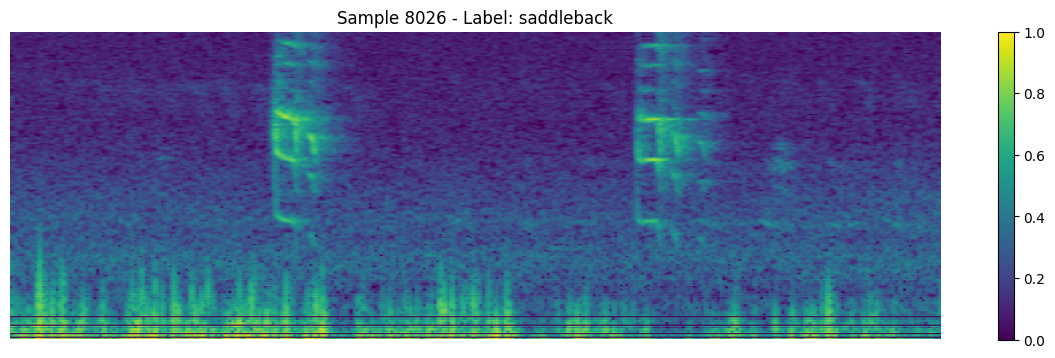

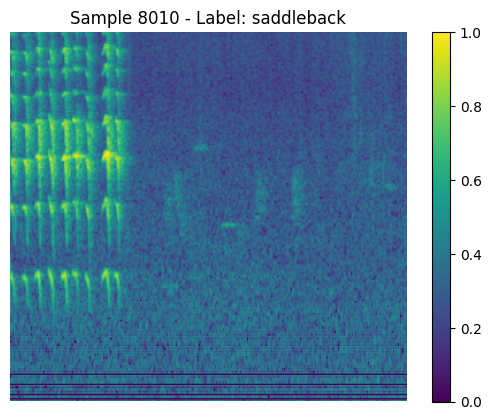

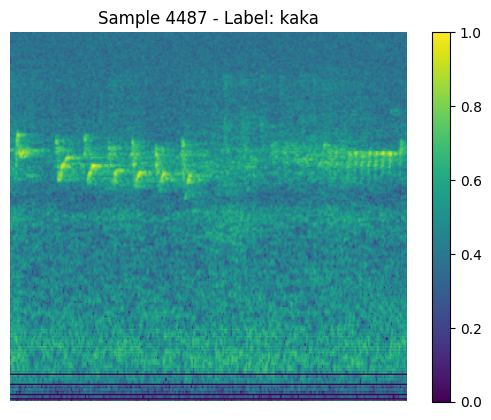

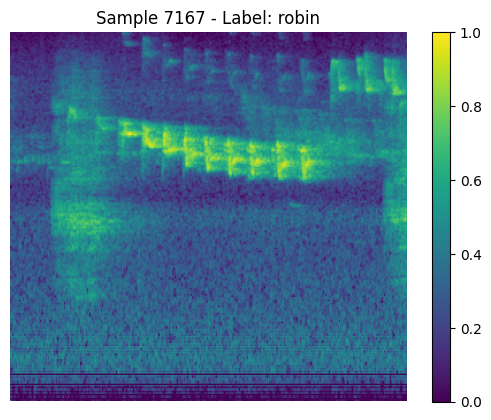

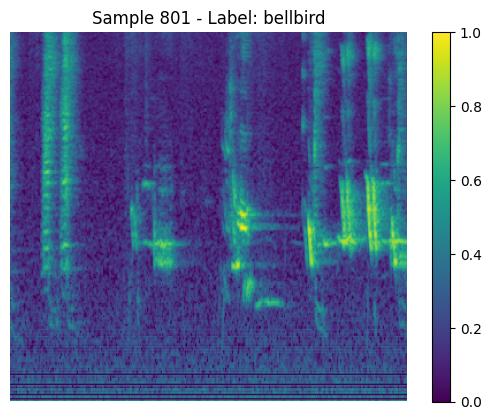

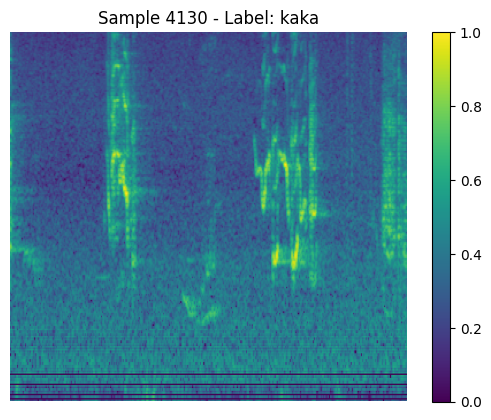

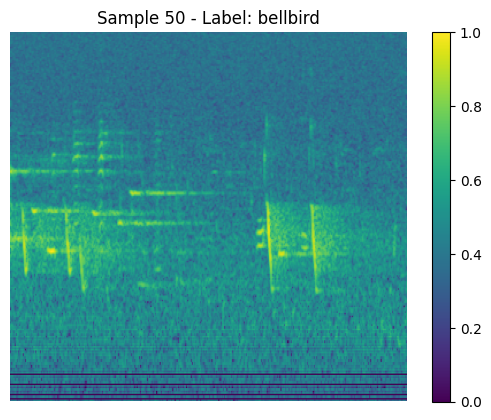

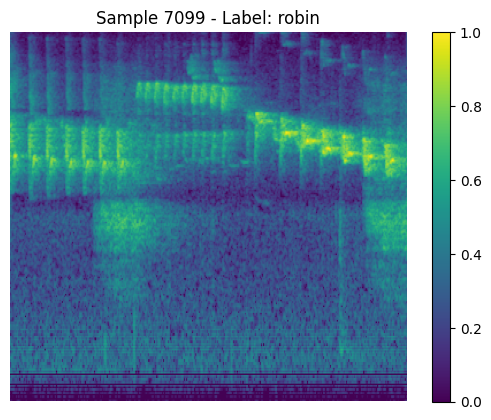

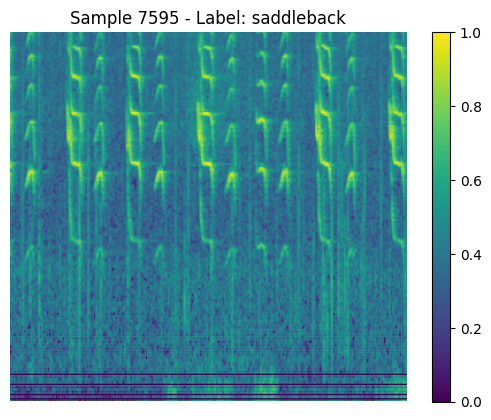

In [6]:
# Display 9 random spectrograms and their labels
# First clear spectrograms folder
if os.path.exists("spectrograms/"):
    print(f"Directory spectrograms/ already exists. Deleting entire folder.")
    shutil.rmtree("spectrograms/")
    os.makedirs("spectrograms/")

fig = plt.figure(figsize=(15, 4))
for plot_idx, i in enumerate(random.sample(range(len(dataset)), 9)):
    y_vis = np.array(dataset[i]["log_mel"])
    y_norm = (y_vis - y_vis.min()) / (y_vis.max() - y_vis.min())
    plt.imshow(y_norm, aspect='auto', origin='lower')
    plt.title(f"Sample {i} - Label: {id_to_label[dataset[i]['label']]}")
    plt.axis("off")
    plt.colorbar()
    plt.savefig(f"spectrograms/sample_{id_to_label[dataset[i]['label']]}_{i}.png")
    plt.show()

# Set up Model architecture

In [7]:
# Split data
train, test = dataset.train_test_split(test_size=0.3, seed=seed).values()
dataset = DatasetDict({"train": train, "test": test})

In [8]:
# SET UP MODEL

def trainable_parameters(model):
    params, trainable = 0, 0
    
    for _, p in model.named_parameters():
        params += p.numel()
        trainable += p.numel() if p.requires_grad else 0

    return f"{model.__class__.__name__} trainable parameters: {trainable:,}/{params:,} ({100 * trainable / params:.2f}%)"

def collate_fn(batch):
    return {
        "pixel_values": torch.stack([torch.tensor(item["pixel_values"]) for item in batch]).to(device),
        "labels": torch.tensor([item["label"] for item in batch], dtype=torch.long).to(device)
    }

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    # Overall metrics
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    prec = precision_metric.compute(predictions=preds, references=labels, average="weighted")["precision"]
    rec = recall_metric.compute(predictions=preds, references=labels, average="weighted")["recall"]
    f1 = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    auc = roc_auc_score(labels, torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy(), multi_class='ovr', average='macro')

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    
    def forward(self, inputs, targets):
        ce_loss = cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class MPSTrainer(Trainer):
    def training_step(self, model, inputs, num_items_in_batch=None):
        model.train()
        inputs = self._prepare_inputs(inputs)

        # Wrap forward pass in autocast for MPS fp16
        with torch.autocast("mps"):
            outputs = model(**inputs)
            loss = outputs.loss

        # Backprop
        loss.backward()
        return loss.detach()

# Model Architecture
callbacks = [EarlyStoppingCallback(early_stopping_patience=5)]
base_model = ViTForImageClassification.from_pretrained(
    model_name, 
    num_labels=len(labels),
    id2label=id_to_label,
    label2id=label_to_id
)

lora = LoraConfig(
    r=lora_rank,
    lora_alpha=lora_rank * 4, # Common practice to set alpha to 4 times the rank
    lora_dropout=0.1,
    target_modules=["query", "key", "value", "dense"], # Attention & MLP layers
    modules_to_save=["classifier"]
)

peft_model = get_peft_model(base_model, lora).to(device)

trainer = MPSTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    tokenizer=processor,
    data_collator=collate_fn,
    callbacks=callbacks,
)

print(trainable_parameters(peft_model))
print("Model set-up complete. Ready to begin training...")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PeftModel trainable parameters: 5,316,106/91,122,452 (5.83%)
Model set-up complete. Ready to begin training...


/var/folders/m9/5g7zcttx2sx_y5pwg05xn1dh0000gn/T/ipykernel_42833/3344293128.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `MPSTrainer.__init__`. Use `processing_class` instead.
  trainer = MPSTrainer(


# Train the model

In [ ]:
# TRAIN MODEL
result = trainer.train()
trainer.log_metrics("train", result.metrics)
trainer.save_metrics("train", result.metrics)

/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


/Users/harrywills/miniconda3/envs/ManuAI/lib/python3.11/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


# Evaluate & Save the model

In [ ]:
# EVALUATE MODEL
metrics = trainer.evaluate(eval_dataset=dataset["test"])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

In [ ]:
# Save final model and processor
base_model.save_pretrained(model_output_dir) # Saves full fine-tuned model (ViTForImageClassification.from_pretrained("./vit-base-manuai"))
processor.save_pretrained(model_output_dir) # Saves image processor (ViTImageProcessor.from_pretrained("./vit-base-manuai"))
print(f"Model fine-tuned and saved to {model_output_dir}")
# Save LoRA adapters
peft_model.save_pretrained(adapters_dir) # Saves only LoRA adapters (PEFTModel.from_pretrained(base_model, "./manuai_lora_adapters"))
print(f"LoRA adapters saved to {adapters_dir}")

# Check metrics of fine-tuned model

In [ ]:
# MODEL METRIC EVALUATION REPORT
# Overall 
print(metrics)

# Per-class
predictions = trainer.predict(dataset["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=-1)

accuracy_per_class = {}
for i, label_name in enumerate(labels):
    idx = (y_true == i) 
    accuracy_per_class[label_name] = (y_pred[idx] == y_true[idx]).mean()

print("Accuracy per class:")
for label, acc in accuracy_per_class.items():
    print(f"{label}: {acc:.2f}")

print(f"Precision & Recall per class")
for i, label_name in enumerate(labels):
    precision = precision_score(y_true, y_pred, average=None)[i]
    recall = recall_score(y_true, y_pred, average=None)[i]
    print(f"{label_name}: Precision: {precision:.2f}, Recall: {recall:.2f}")

# Confusion Matrix (plot)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def apply_thresholds(probs, thresholds):
    preds = []
    for p in probs:
        # classes above their threshold
        above = [i for i, th in enumerate(thresholds) if p[i] >= th]
        if len(above) == 0:
            preds.append(int(np.argmax(p)))  # fallback
        elif len(above) == 1:
            preds.append(int(above[0]))
        else:
            # multiple candidates: pick the one with highest prob among them
            chosen = int(np.argmax(p[above]))
            preds.append(above[chosen])
    return np.array(preds)

logits = predictions.predictions  # shape (N, n_classes)
probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()

n_classes = probs.shape[1]
best_thresholds = np.zeros(n_classes, dtype=float)

for i in range(n_classes):
    y_true_i = (y_true == i).astype(int)
    prob_i = probs[:, i]
    # if no positives or all positives, set threshold 0.5
    if y_true_i.sum() == 0 or y_true_i.sum() == len(y_true_i):
        best_thresholds[i] = 0.5
        continue
    precision, recall, thresholds = precision_recall_curve(y_true_i, prob_i)
    # thresholds length = len(precision) - compute F1 for the threshold points
    f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-12)
    if np.isnan(f1_scores).all():
        best_thresholds[i] = 0.5
    else:
        best_idx = np.nanargmax(f1_scores)
        best_thresholds[i] = thresholds[best_idx]

print("Best thresholds per class:", {id_to_label[i]: float(best_thresholds[i]) for i in range(n_classes)})

preds_thresh = apply_thresholds(probs, best_thresholds)
# Present classification report
report = classification_report(y_true, preds_thresh, target_names=labels)
print("Classification Report of Model with Optimal Thresholds:\n", report)

# ZIP fine-tuned model

In [ ]:
# ZIP MODEL & ADAPTERS
zip -r manuai_models.zip vit-base-manuai manuai_lora_adapter
print("Model and adapters zipped into manuai_models.zip")